In [1]:
import copy
import cv2
import glob
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import os
import seaborn as sns
from astropy.io import fits
import torch
from torch.utils.data import Dataset
from torchmetrics import Dice
from torchmetrics import Dice, JaccardIndex
import segmentation_models_pytorch as smp

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/home/dario/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
hiperparametros = {'nombre_notebook': 'Evaluation_NISP_H_1000_v4imgs.ipynb',
                    'nombre_experimento' : 'Evaluation_NISP_H_1000_v4imgs',
                    'nombre_mejor_modelo_entrenado' : 'NISP_H_1000imgs_v4',
                    'device' : torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
                    'ruta_galaxias' : 'galaxies_test_NISP_H/galaxy_and_stream_convolved*.fits',
                    'ruta_mascaras' : '../masks_train_NISP_H/mask_',
                    'ancho_imagen_original' : 200,
                    'alto_imagen_original' : 200,
                    'ancho_imagen_deseado' : 224,
                    'alto_imagen_deseado' : 224}

In [3]:
def get_galaxy_number(galaxy_name:str):
    return os.path.basename(galaxy_name).split('_')[4]

def get_galaxy_magnitude(galaxy_name:str):
    return os.path.basename(galaxy_name).split('_')[5]

def normalize_01(inp: np.ndarray):
    """Squash image input to the value range [0, 1] (no clipping)"""
    inp_out = (inp - np.min(inp)) / np.ptp(inp)
    return inp_out

def imagen_logaritmica(img: np.ndarray)->np.ndarray:
    """
    Escalamos de forma logarítmica la imagen para aumentar el contraste
    """
    img_log = np.log(img, where=(img>0))
    valor_minimo = np.min(img_log)
    np.putmask(img_log, img!=0, img_log+abs(valor_minimo))
    return img_log

In [4]:
class MyDataset(Dataset):
    """
    Dataset básico sin ningún tipo de augmentation
    """
    def __init__(self, galaxias_con_colas_de_marea, transform=None):
        """
        Constructor del dataset
        @param galaxias_con_colas_de_marea: Lista de rutas a los ficheros que contienen los datos de las galaxias
        """
        self.galaxias_con_colas_de_marea = galaxias_con_colas_de_marea
        self.transform=transform

    def __getitem__(self, index):
        #Abrimos la imagen de la galaxia con cola de marea
        ruta = self.galaxias_con_colas_de_marea[index]
        magnitud_real = get_galaxy_magnitude(ruta)
        galaxy_fits = fits.open(self.galaxias_con_colas_de_marea[index])
        x = galaxy_fits[0].data.astype(np.float32)
        #Abrimos la mascara correspondiente a la imagen
        numero_galaxia = get_galaxy_number(self.galaxias_con_colas_de_marea[index])
        magnitud_galaxia = get_galaxy_magnitude(self.galaxias_con_colas_de_marea[index])
        
        y = np.array(cv2.imread(hiperparametros['ruta_mascaras']+str(numero_galaxia)+"_"+str(magnitud_galaxia)+".png",0)).astype(np.float32)
        #x = normalize_01(x)
        x_tensor_visualizar = copy.deepcopy(x)
        x = imagen_logaritmica(x)

        x = normalize_01(x)
        # Assuming 'input_item' is your input image
        x = cv2.resize(x, (hiperparametros['ancho_imagen_deseado'], hiperparametros['alto_imagen_deseado']))
        y = cv2.resize(y, (hiperparametros['ancho_imagen_deseado'], hiperparametros['alto_imagen_deseado']))
        if(self.transform is not None):
            augmented = self.transform(image=x, mask=y)
            x_tensor= augmented["image"]
            y_tensor= augmented["mask"].long()
        else:
            x_tensor = torch.from_numpy(x).float()
            x_tensor=torch.unsqueeze(x_tensor, dim=0)
            y_tensor = torch.from_numpy(y).long()
        
        #Hacemos reshape de los tensores
        y_tensor=torch.unsqueeze(y_tensor, dim=0)
        return x_tensor, y_tensor, ruta, magnitud_real, x_tensor_visualizar
    
    def __len__(self):
        """
        Devuelve la longitud del dataset
        """
        return len(self.galaxias_con_colas_de_marea)

In [5]:
dice = Dice(num_classes=2, average='macro', ignore_index=0)
iou = JaccardIndex(task='multiclass', num_classes=2, average='macro', ignore_index=0)
imagenes_test = glob.glob(hiperparametros['ruta_galaxias'])
imagenes_test.sort()
#Cargamos el dataset de test
test_dataset= MyDataset(imagenes_test)
print("Number of valid images: " + str(len(imagenes_test)))
device = hiperparametros['device']
#dice.to(device)

Number of valid images: 1749


In [6]:
unet = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)

In [7]:
#Cargamos el modelo previamente entrenado
ruta_modelo = hiperparametros['nombre_mejor_modelo_entrenado']
mejor_modelo = unet
mejor_modelo.load_state_dict(torch.load(ruta_modelo))
mejor_modelo.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

Ruta: galaxies_test_NISP_H/galaxy_and_stream_convolved_1000_0.05_NISP_H_in_EUC_MER_BGSUB-MOSAIC-NIR-H_TILE101019127-6715A1_20240112T190340.364333Z_00.00.fits
Magnitud: 0.05, Dice: 0.6794, IOU: 0.7542 :


/tmp/ipykernel_1320888/3509897227.py:69: RuntimeWarning: divide by zero encountered in log10
  x = axs0.imshow(-2.5*np.log10(x_tensor_visualizar)+zp+(5*np.log10(pix_scale)), origin='lower', cmap='viridis',vmin=20,vmax=32, interpolation="none")


Ruta: galaxies_test_NISP_H/galaxy_and_stream_convolved_1000_0.15_NISP_H_in_EUC_MER_BGSUB-MOSAIC-NIR-H_TILE101019127-6715A1_20240112T190340.364333Z_00.00.fits
Magnitud: 0.15, Dice: 0.1774, IOU: 0.1594 :
Ruta: galaxies_test_NISP_H/galaxy_and_stream_convolved_1000_0.1_NISP_H_in_EUC_MER_BGSUB-MOSAIC-NIR-H_TILE101019127-6715A1_20240112T190340.364333Z_00.00.fits
Magnitud: 0.1, Dice: 0.4407, IOU: 0.3482 :
Ruta: galaxies_test_NISP_H/galaxy_and_stream_convolved_1000_0.25_NISP_H_in_EUC_MER_BGSUB-MOSAIC-NIR-H_TILE101019127-6715A1_20240112T190340.364333Z_00.00.fits
Magnitud: 0.25, Dice: 0.0, IOU: 0.0 :
Ruta: galaxies_test_NISP_H/galaxy_and_stream_convolved_1000_0.2_NISP_H_in_EUC_MER_BGSUB-MOSAIC-NIR-H_TILE101019127-6715A1_20240112T190340.364333Z_00.00.fits
Magnitud: 0.2, Dice: 0.0, IOU: 0.0 :
Ruta: galaxies_test_NISP_H/galaxy_and_stream_convolved_1000_0.4_NISP_H_in_EUC_MER_BGSUB-MOSAIC-NIR-H_TILE101019127-6715A1_20240112T190340.364333Z_00.00.fits
Magnitud: 0.4, Dice: 0.0, IOU: 0.0 :
Ruta: galaxies

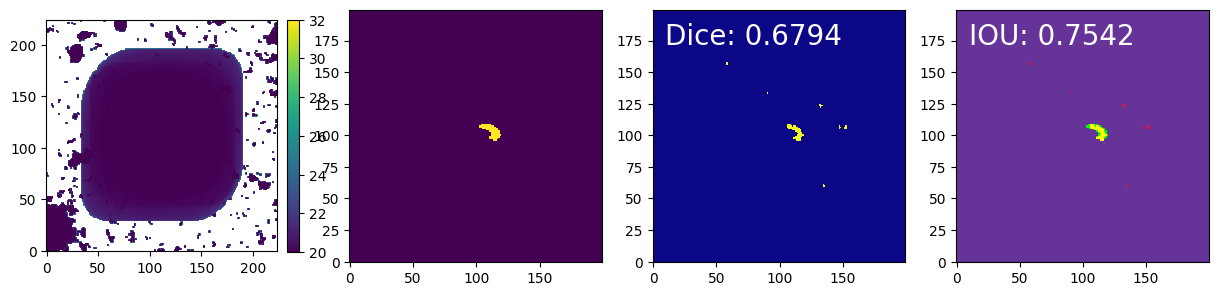

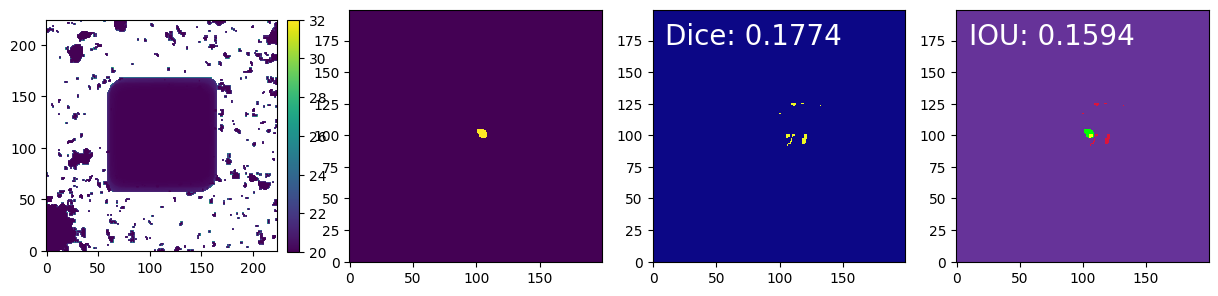

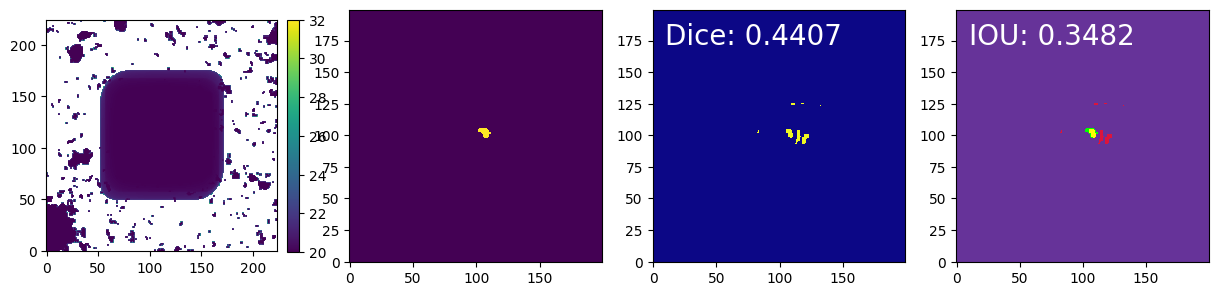

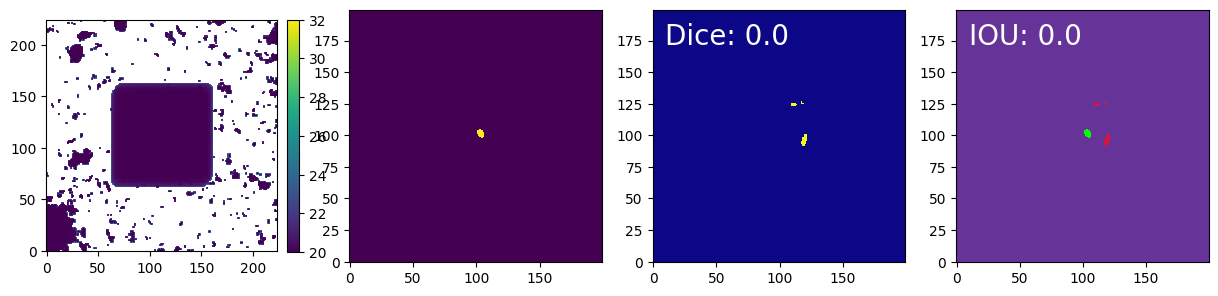

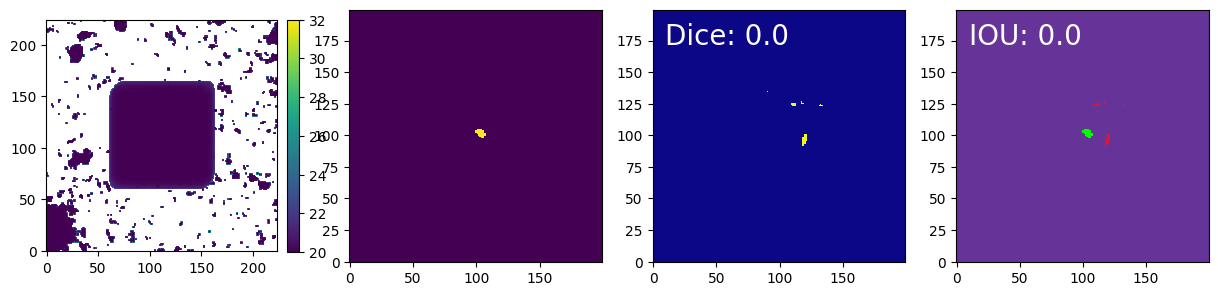

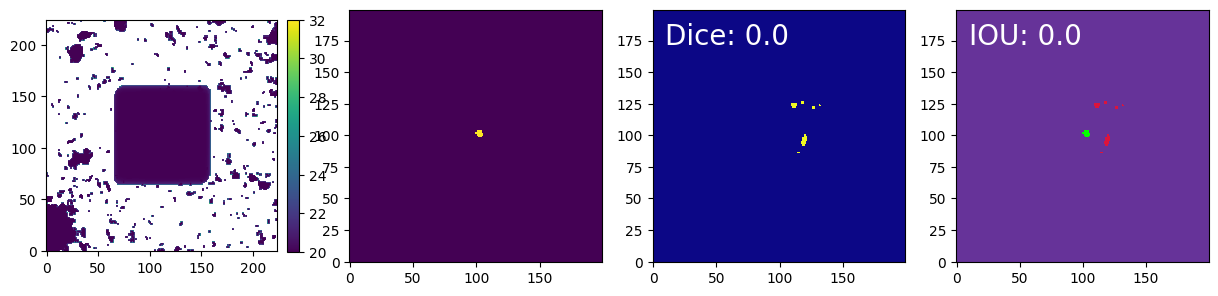

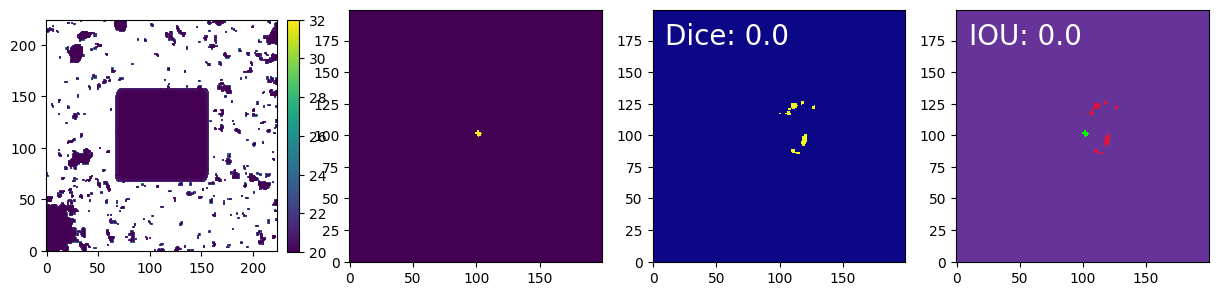

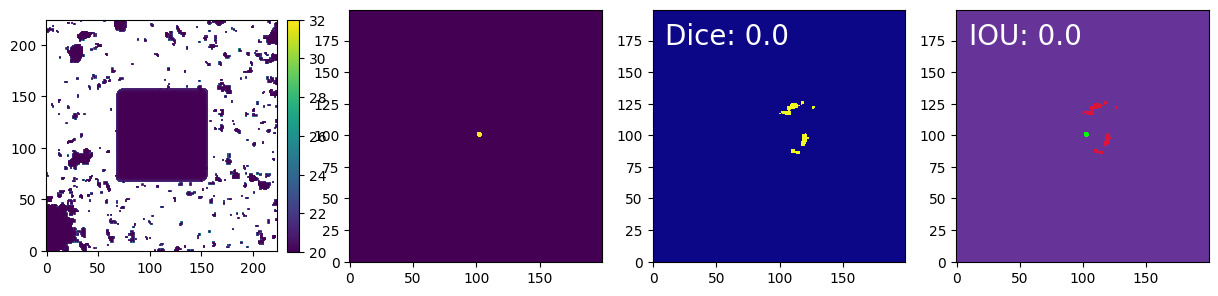

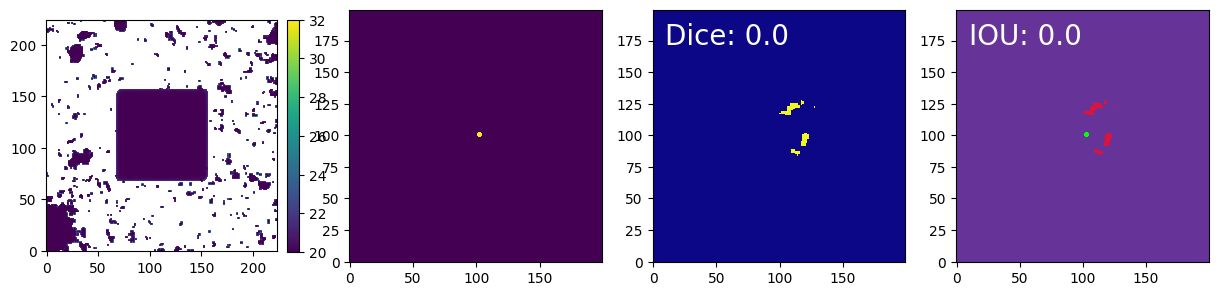

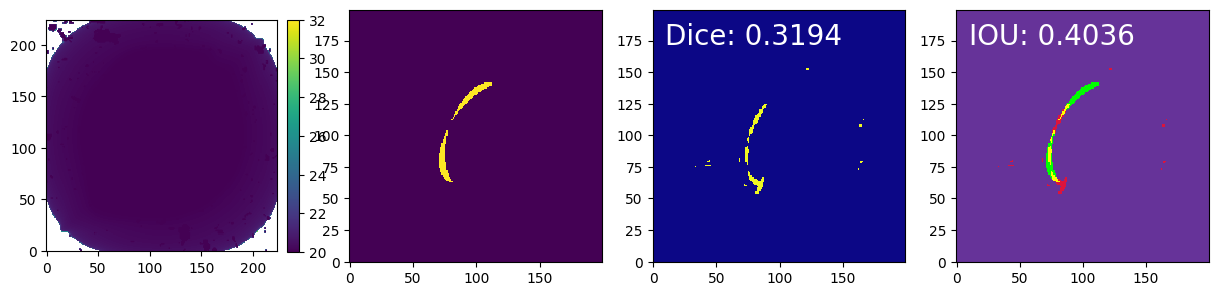

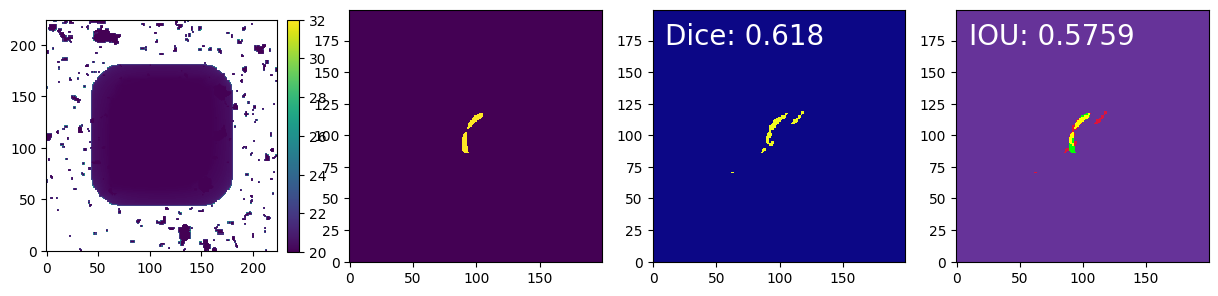

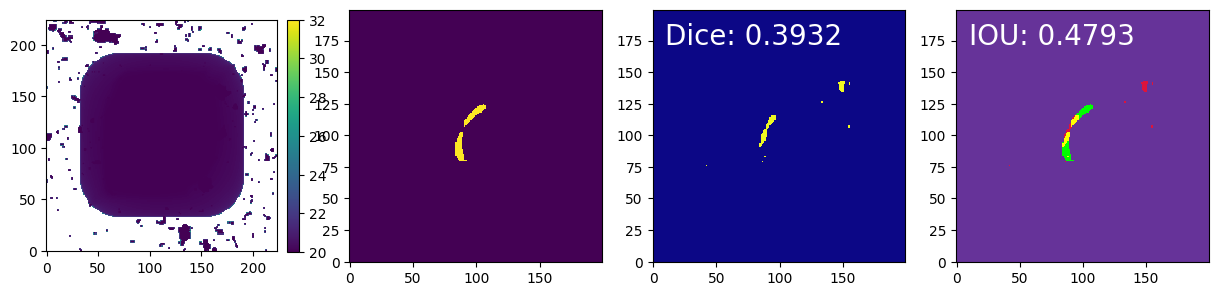

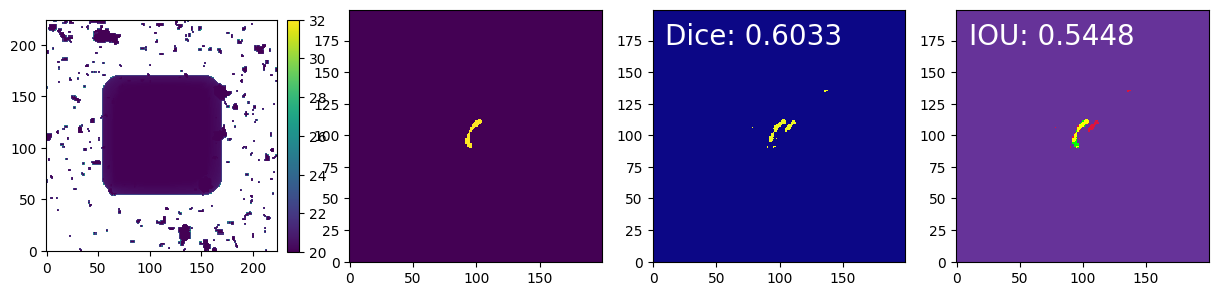

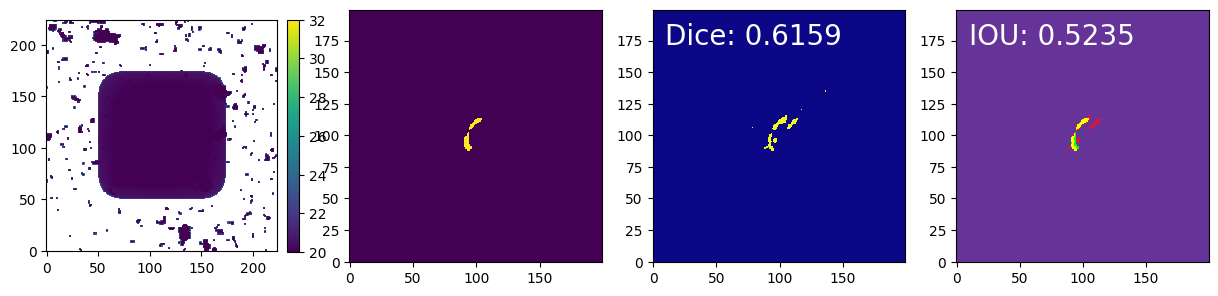

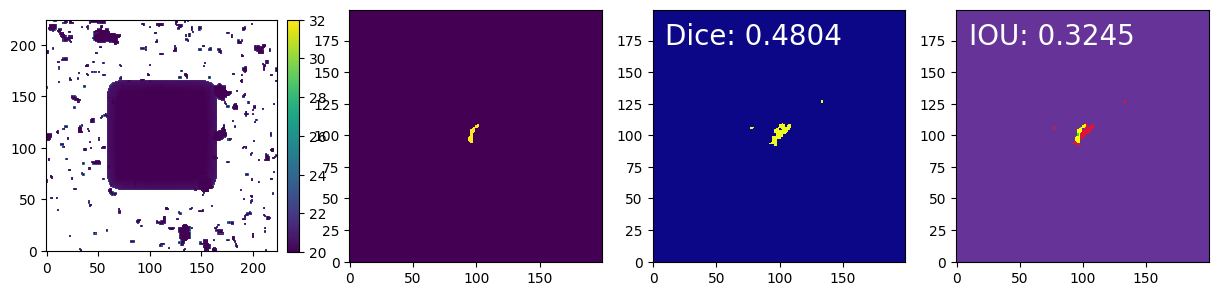

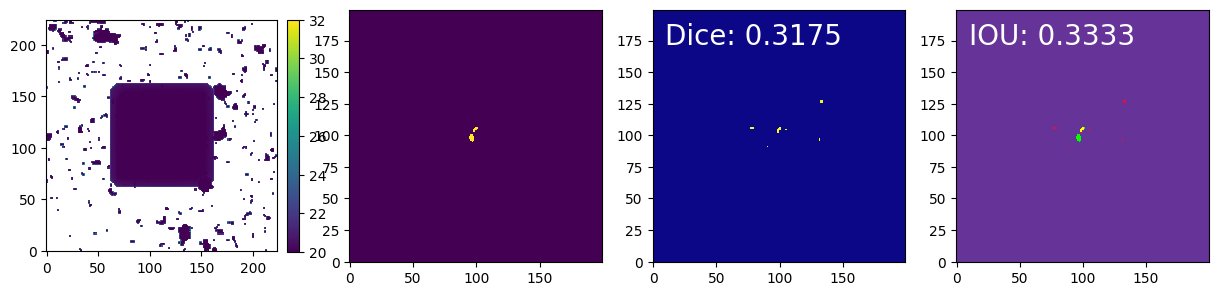

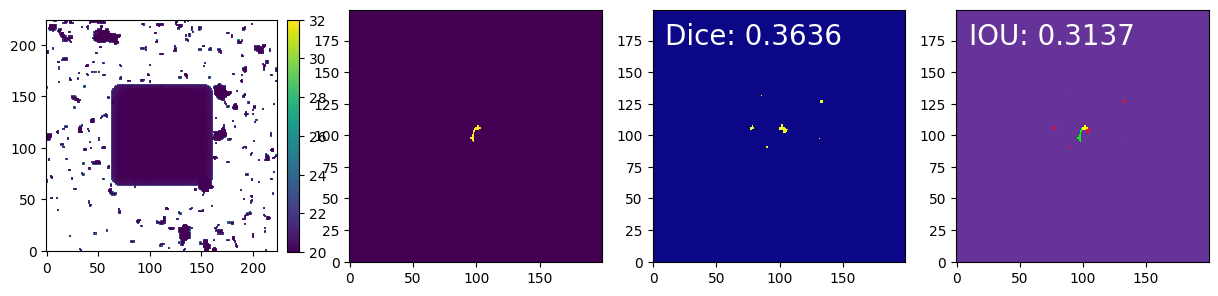

In [8]:
resultados_dice = {
    '0.05':[],
    '0.1':[],
    '0.15':[],
    '0.2':[],
    '0.25':[],
    '0.4':[],
    '0.6':[],
    '0.8':[],
    '1':[],
}
resultados_iou = {
    '0.05':[],
    '0.1':[],
    '0.15':[],
    '0.2':[],
    '0.25':[],
    '0.4':[],
    '0.6':[],
    '0.8':[],
    '1':[],
}
# With photos
ancho = hiperparametros['ancho_imagen_deseado']
alto =hiperparametros['alto_imagen_deseado']
mejor_modelo.eval()
pasos_test=0
dice_medio_test=0
iou_medio_test = 0
zp = 24.4 # TODO Preguntar a Fer
pix_scale = 0.1 # TODO Preguntar a Fer
for i in range(int(len(test_dataset) * 0.01)):
    item_dataset = test_dataset.__getitem__(i)
    item_x = item_dataset[0].reshape((1,1,ancho,alto)).cpu().detach().squeeze().numpy()
    item_label = item_dataset[1].reshape((1,1,ancho,alto)).cpu().detach().squeeze().numpy()
    x_tensor_visualizar = item_dataset[0].reshape((1,1,ancho,alto)).cpu().detach().squeeze().numpy()
    #Si la máscara es vacía no intentamos segmentarla, para que no cuente en el dice
    if(np.count_nonzero(item_label)!=0):
        #Obtenemos predicción de la red
        prediccion_item_tensor = mejor_modelo(item_dataset[0].reshape((1,1,ancho,alto)).to(device)).cpu().detach().squeeze()   
        mascara_predicha = torch.argmax(prediccion_item_tensor, dim=0).numpy()
        valor_dice = dice(torch.from_numpy(item_label), torch.from_numpy(mascara_predicha))
        valor_iou = iou(torch.from_numpy(item_label), torch.from_numpy(mascara_predicha))
        magnitud = item_dataset[3]
        print("Ruta: "+item_dataset[2]+ "\nMagnitud: "+ magnitud + ", Dice: "+str(round(valor_dice.item(), 4))+", IOU: "+str(round(valor_iou.item(), 4))+" :")
        resultados_dice[magnitud].append(valor_dice.item())
        resultados_iou[magnitud].append(valor_iou.item())
        dice_medio_test += valor_dice.item()
        iou_medio_test += valor_iou.item()
        pasos_test += 1
        #Mostramos imagen, mascara y mascara predicha
        item_x = cv2.resize(item_x.astype(np.float32), (hiperparametros['ancho_imagen_original'], hiperparametros['alto_imagen_original']), interpolation = cv2.INTER_NEAREST)
        
        item_label = cv2.resize(item_label.astype(np.uint8), (hiperparametros['ancho_imagen_original'], hiperparametros['alto_imagen_original']), interpolation = cv2.INTER_NEAREST)   
        mascara_predicha = cv2.resize(mascara_predicha.astype(np.float32), (hiperparametros['ancho_imagen_original'], hiperparametros['alto_imagen_original']), interpolation = cv2.INTER_NEAREST)     
        zeros = np.zeros((hiperparametros['ancho_imagen_original'], hiperparametros['ancho_imagen_original']))
        ones = np.ones((hiperparametros['ancho_imagen_original'], hiperparametros['ancho_imagen_original']))

        cmap = colors.ListedColormap(['rebeccapurple', 'yellow', 'crimson', 'lime'])
        bounds=[0,1,2,3,4]
        norm = colors.BoundaryNorm(bounds, cmap.N)
        dif = np.zeros((hiperparametros['ancho_imagen_original'], hiperparametros['ancho_imagen_original']))
        dif[ ( item_label == zeros ) & (mascara_predicha == zeros) ] = 0
        dif[ (item_label == ones ) & (mascara_predicha == ones) ] = 1
        dif[ (item_label == zeros) & (mascara_predicha == ones) ] = 2
        dif[ (item_label == ones) & (mascara_predicha == zeros)] = 3

        fig, (axs0, axs1, axs2, axs3) = plt.subplots(1,4, figsize = (15,15))
        x = axs0.imshow(-2.5*np.log10(x_tensor_visualizar)+zp+(5*np.log10(pix_scale)), origin='lower', cmap='viridis',vmin=20,vmax=32, interpolation="none")
        fig.colorbar(x, ax=axs0, fraction=0.046, pad=0.04)

        axs1.imshow(item_label, interpolation='none', origin="lower")
        axs2.imshow(mascara_predicha, interpolation='none', origin="lower", cmap="plasma")
        axs2.text(0.05, 0.95, "Dice: "+str(round(valor_dice.item(), 4)), color='white', fontsize=20, ha='left', va='top', transform=axs2.transAxes)
        axs3.imshow(dif, interpolation='none', origin="lower", cmap=cmap,  norm=norm)
        axs3.text(0.05, 0.95, "IOU: "+str(round(valor_iou.item(), 4)), color='white', fontsize=20, ha='left', va='top', transform=axs3.transAxes)
        #plt.imshow()
        
        #Save figures
        """
        fig0, ax0 = plt.subplots()
        ax0.imshow(axs0.get_images()[0].get_array(), interpolation='none', origin="lower")
        ax0.axis('off')
        fig0.savefig("images_paper_vis/"+ item_dataset[2].split('/')[-1]+'_input.png', bbox_inches='tight', pad_inches=0)
        
        fig1, ax1 = plt.subplots()
        ax1.imshow(axs1.get_images()[0].get_array(), interpolation='none', origin="lower")
        ax1.axis('off')
        fig1.figure.savefig("images_paper_vis/"+ item_dataset[2].split('/')[-1]+'_label.png', bbox_inches='tight', pad_inches=0)
        
        fig2, ax2 = plt.subplots()
        ax2.imshow(axs2.get_images()[0].get_array(), interpolation='none', origin="lower", cmap="plasma")
        ax2.axis('off')
        ax2.text(0.05, 0.95, "Dice: "+str(round(valor_dice.item(), 4)), color='white', fontsize=20, ha='left', va='top', transform=ax2.transAxes)
        fig2.figure.savefig("images_paper_vis/"+ item_dataset[2].split('/')[-1]+'_prediction.png', bbox_inches='tight', pad_inches=0)
        fig3, ax3 = plt.subplots()
        ax3.imshow(axs3.get_images()[0].get_array(), interpolation='none', origin="lower", cmap=cmap,  norm=norm)
        ax3.axis('off')
        ax3.text(0.05, 0.95, "Dice: "+str(round(valor_dice.item(), 4)), color='white', fontsize=20, ha='left', va='top', transform=ax3.transAxes)
        fig3.figure.savefig("images_paper_vis/"+ item_dataset[2].split('/')[-1]+'_comparison.png', bbox_inches='tight', pad_inches=0)
        """


In [9]:
resultados_dice = {
    '0.05':[],
    '0.1':[],
    '0.15':[],
    '0.2':[],
    '0.25':[],
    '0.4':[],
    '0.6':[],
    '0.8':[],
    '1':[],
}
resultados_iou = {
    '0.05':[],
    '0.1':[],
    '0.15':[],
    '0.2':[],
    '0.25':[],
    '0.4':[],
    '0.6':[],
    '0.8':[],
    '1':[],
}
# Without photos
ancho = hiperparametros['ancho_imagen_deseado']
alto =hiperparametros['alto_imagen_deseado']
mejor_modelo.eval()
pasos_test=0
dice_medio_test=0
iou_medio_test = 0
zp = 30.137
pix_scale = 0.1
for i in range(int(len(test_dataset))):
    item_dataset = test_dataset.__getitem__(i)
    item_x = item_dataset[0].reshape((1,1,ancho,alto)).cpu().detach().squeeze().numpy()
    item_label = item_dataset[1].reshape((1,1,ancho,alto)).cpu().detach().squeeze().numpy()
    #Si la máscara es vacía no intentamos segmentarla, para que no cuente en el dice
    if(np.count_nonzero(item_label)!=0):
        #Obtenemos predicción de la red
        prediccion_item_tensor = mejor_modelo(item_dataset[0].reshape((1,1,ancho,alto)).to(device)).cpu().detach().squeeze()   
        mascara_predicha = torch.argmax(prediccion_item_tensor, dim=0).numpy()
        valor_dice = dice(torch.from_numpy(item_label), torch.from_numpy(mascara_predicha))
        valor_iou = iou(torch.from_numpy(item_label), torch.from_numpy(mascara_predicha))
        magnitud = item_dataset[3]
        print("Ruta: "+item_dataset[2]+ "\nMagnitud: "+ magnitud + ", Dice: "+str(round(valor_dice.item(), 4))+" :")
        resultados_dice[magnitud].append(valor_dice.item())
        resultados_iou[magnitud].append(valor_iou.item())
        dice_medio_test += valor_dice.item()
        iou_medio_test += valor_iou.item()
        pasos_test += 1
        #Mostramos imagen, mascara y mascara predicha
        item_x = cv2.resize(item_x.astype(np.float32), (hiperparametros['ancho_imagen_original'], hiperparametros['alto_imagen_original']), interpolation = cv2.INTER_NEAREST)     
        item_label = cv2.resize(item_label.astype(np.uint8), (hiperparametros['ancho_imagen_original'], hiperparametros['alto_imagen_original']), interpolation = cv2.INTER_NEAREST)   
        mascara_predicha = cv2.resize(mascara_predicha.astype(np.float32), (hiperparametros['ancho_imagen_original'], hiperparametros['alto_imagen_original']), interpolation = cv2.INTER_NEAREST)     
        #fig, (axs0, axs1, axs2) = plt.subplots(1,3, figsize = (15,15))
        #axs0.imshow(item_x, interpolation='none', origin="lower")
        #axs1.imshow(item_label, interpolation='none', origin="lower")
        #axs2.imshow(mascara_predicha, interpolation='none', origin="lower")
        #plt.show()
        #guardar_imagen_plt(item_x, "item_x", i)
        #guardar_imagen_plt(item_label, "item_label", i)
        #guardar_imagen_plt(mascara_predicha, "mascara_predicha", i)


Ruta: galaxies_test_NISP_H/galaxy_and_stream_convolved_1000_0.05_NISP_H_in_EUC_MER_BGSUB-MOSAIC-NIR-H_TILE101019127-6715A1_20240112T190340.364333Z_00.00.fits
Magnitud: 0.05, Dice: 0.6794 :
Ruta: galaxies_test_NISP_H/galaxy_and_stream_convolved_1000_0.15_NISP_H_in_EUC_MER_BGSUB-MOSAIC-NIR-H_TILE101019127-6715A1_20240112T190340.364333Z_00.00.fits
Magnitud: 0.15, Dice: 0.1774 :
Ruta: galaxies_test_NISP_H/galaxy_and_stream_convolved_1000_0.1_NISP_H_in_EUC_MER_BGSUB-MOSAIC-NIR-H_TILE101019127-6715A1_20240112T190340.364333Z_00.00.fits
Magnitud: 0.1, Dice: 0.4407 :
Ruta: galaxies_test_NISP_H/galaxy_and_stream_convolved_1000_0.25_NISP_H_in_EUC_MER_BGSUB-MOSAIC-NIR-H_TILE101019127-6715A1_20240112T190340.364333Z_00.00.fits
Magnitud: 0.25, Dice: 0.0 :
Ruta: galaxies_test_NISP_H/galaxy_and_stream_convolved_1000_0.2_NISP_H_in_EUC_MER_BGSUB-MOSAIC-NIR-H_TILE101019127-6715A1_20240112T190340.364333Z_00.00.fits
Magnitud: 0.2, Dice: 0.0 :
Ruta: galaxies_test_NISP_H/galaxy_and_stream_convolved_1000_0.4_N

In [10]:
dice_test_medio_total=dice_medio_test/pasos_test
print("Dice_medio_total="+str(dice_test_medio_total))

Dice_medio_total=0.23650301287412376


In [11]:
iou_test_medio_total=iou_medio_test/pasos_test
print("IOU_medio_total="+str(iou_test_medio_total))

IOU_medio_total=nan


In [12]:
# Filtrar NaNs y calcular la media para resultados_dice
dices_medios_por_magnitud = [np.mean([x for x in lista if not np.isnan(x)]) for lista in resultados_dice.values()]
print(dices_medios_por_magnitud)
# Filtrar NaNs y calcular la media para resultados_iou
ious_medios_por_magnitud = [np.mean([x for x in lista if not np.isnan(x)]) for lista in resultados_iou.values()]
print(ious_medios_por_magnitud)

[0.2232888597637022, 0.3179515577297695, 0.32773457959792907, 0.30843981933977566, 0.29692374321580084, 0.22943155353735248, 0.17160204478392477, 0.12417692535041654, 0.11411228732151144]
[0.22891126045999327, 0.3558071634445264, 0.3728349077536578, 0.3703214660721836, 0.3540361509849437, 0.27250022586296374, 0.22614196989581817, 0.15460557136738803, 0.13396742607027978]


/tmp/ipykernel_1320888/1810617054.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(resultados_dice.keys()), y=dices_medios_por_magnitud, palette=bar_colors)


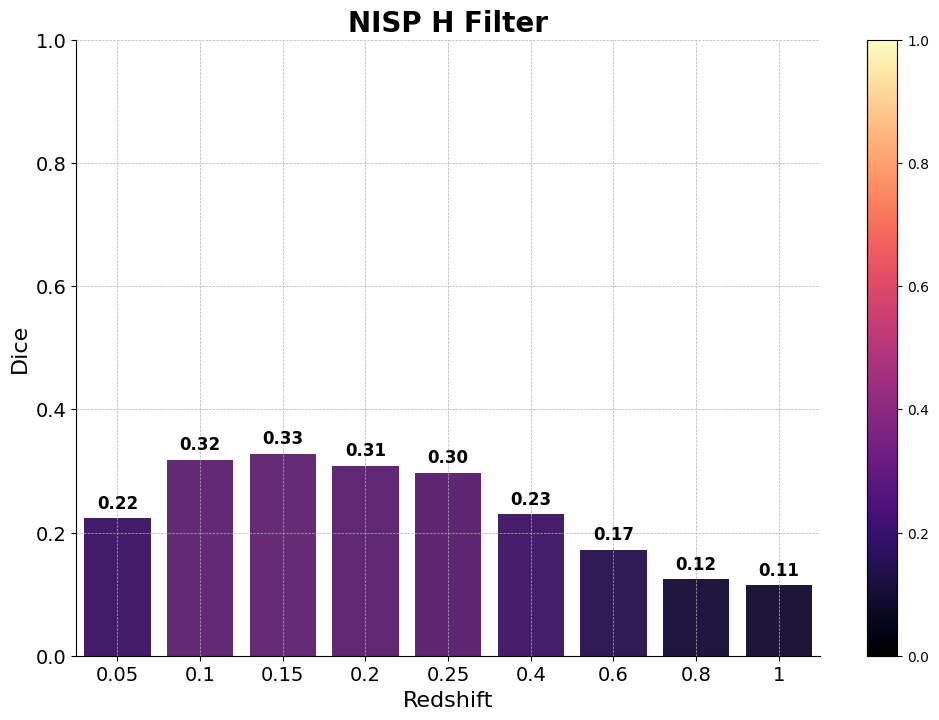

In [16]:
# Crear una paleta de colores en función de los valores alcanzados, normalizada entre 0 y 1
norm = plt.Normalize(0, 1)
sm = plt.cm.ScalarMappable(cmap="magma", norm=norm)
sm.set_array([])

# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))

# Crear el gráfico de barras
bar_colors = [sm.to_rgba(valor) for valor in dices_medios_por_magnitud]
ax = sns.barplot(x=list(resultados_dice.keys()), y=dices_medios_por_magnitud, palette=bar_colors)

# Ajustar los límites del eje y entre 0 y 1
ax.set_ylim(0, 1)

# Añadir etiquetas con los valores sobre las barras
for i, valor in enumerate(dices_medios_por_magnitud):
    ax.text(i, valor + 0.01, f'{valor:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Añadir un título y ajustar etiquetas
plt.title('NISP H Filter', fontsize=20, fontweight='bold')
plt.xlabel('Redshift', fontsize=16)
plt.ylabel('Dice', fontsize=16)

# Ajustar el tamaño de las etiquetas de los ejes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Añadir líneas de cuadrícula
ax.grid(True, linestyle='--', linewidth=0.5)

# Añadir la barra de color (colorbar)
cbar = plt.colorbar(sm, ax=ax)

# Mejorar el diseño general
sns.despine()
#plt.savefig('images_paper/vis_filter_dice.png', dpi=300, bbox_inches='tight')
# Mostrar el gráfico
plt.show()

/tmp/ipykernel_1320888/3070687478.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(resultados_dice.keys()), y=ious_medios_por_magnitud, palette=bar_colors)


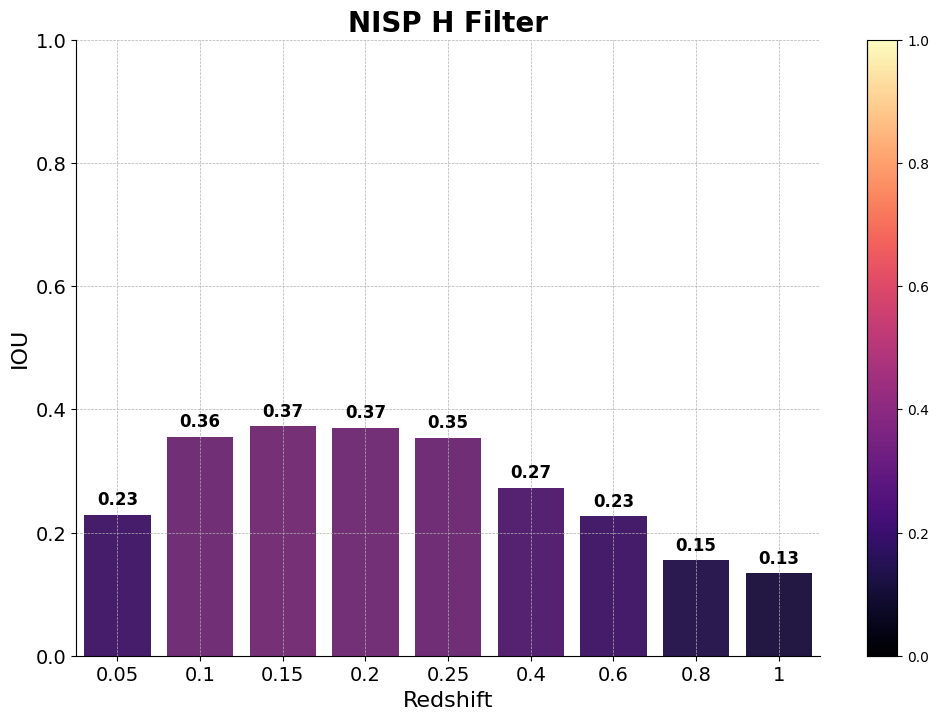

In [17]:
# Crear una paleta de colores en función de los valores alcanzados, normalizada entre 0 y 1
norm = plt.Normalize(0, 1)
sm = plt.cm.ScalarMappable(cmap="magma", norm=norm)
sm.set_array([])

# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))

# Crear el gráfico de barras
bar_colors = [sm.to_rgba(valor) for valor in ious_medios_por_magnitud]
ax = sns.barplot(x=list(resultados_dice.keys()), y=ious_medios_por_magnitud, palette=bar_colors)

# Ajustar los límites del eje y entre 0 y 1
ax.set_ylim(0, 1)

# Añadir etiquetas con los valores sobre las barras
for i, valor in enumerate(ious_medios_por_magnitud):
    ax.text(i, valor + 0.01, f'{valor:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Añadir un título y ajustar etiquetas
plt.title('NISP H Filter', fontsize=20, fontweight='bold')
plt.xlabel('Redshift', fontsize=16)
plt.ylabel('IOU', fontsize=16)

# Ajustar el tamaño de las etiquetas de los ejes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Añadir líneas de cuadrícula
ax.grid(True, linestyle='--', linewidth=0.5)

# Añadir la barra de color (colorbar)
cbar = plt.colorbar(sm, ax=ax)

# Mejorar el diseño general
sns.despine()
#plt.savefig('images_paper/vis_filter_dice.png', dpi=300, bbox_inches='tight')
# Mostrar el gráfico
plt.show()